[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vietanhdev/sdc-tutorial/blob/master/notebooks/Traffic-Sign-Classifier-Training.ipynb)

# Build your own self-driving car on simulation - Part 3: Train your own traffic sign classifier

Develop your own self-driving algorithms, from lane line detection, traffic sign, and car control.

**Author:** [vietanhdev](https://github.com/vietanhdev).


In [ ]:
# Import Tensorflow and check version
# All below code was tested with Tensorflow 2.7.0
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
# Import other packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import glob
import time
import cv2
import os

**Hyperparams:**

In [ ]:
num_epochs = 45
learning_rate = 0.001
batch_size = 64

## I. Data preparation

We prepared an traffic sign classification dataset containing 7 classes: 6 traffic sign classes and 1 unknown class.
After following block, dataset will be downloaded and extracted to `/content/data_raw/<sign_name>` folders. This dataset was prepared from [VIA Dataset 1.0](https://via.makerviet.org/vi/docs/datasets/via-datasets-1-0/) and some data from [ImageNet](https://image-net.org/).

### Download the data

In [ ]:
# Remove old data
!rm -rf /content/data
!rm -rf /content/data_raw

In [ ]:
!mkdir /content/data_raw
%cd /content/data_raw
# Download the dataset
!gdown  https://drive.google.com/uc?id=1zsLnS1uh1mS5l0vLC4YuXItHmiPR7KG9
# Extract
!unzip -qo traffic_sign_classification_data_v2.zip

/content/data_raw
Downloading...
From: https://drive.google.com/uc?id=1zsLnS1uh1mS5l0vLC4YuXItHmiPR7KG9
To: /content/data_raw/traffic_sign_classification_data_v2.zip
100% 192M/192M [00:01<00:00, 175MB/s]


In [ ]:
# Get all images
%cd /content/data_raw
all_img_paths = list(paths.list_images("."))
print(all_img_paths[:10])

/content/data_raw
['./04_no_right/08730.jpg', './04_no_right/08885.jpg', './04_no_right/01331.jpg', './04_no_right/01853.jpg', './04_no_right/00386.jpg', './04_no_right/03591.jpg', './04_no_right/00537.jpg', './04_no_right/07390.jpg', './04_no_right/02913.jpg', './04_no_right/06764.jpg']


### Shuffle and visualize

In [ ]:
# Shuffle the image paths and preview
np.random.seed(0)
random.shuffle(all_img_paths)
print(all_img_paths[:5])

['./05_straight/07988.jpg', './03_right/01740.jpg', './00_unknown/21439.jpg', './03_right/08355.jpg', './03_right/06740.jpg']


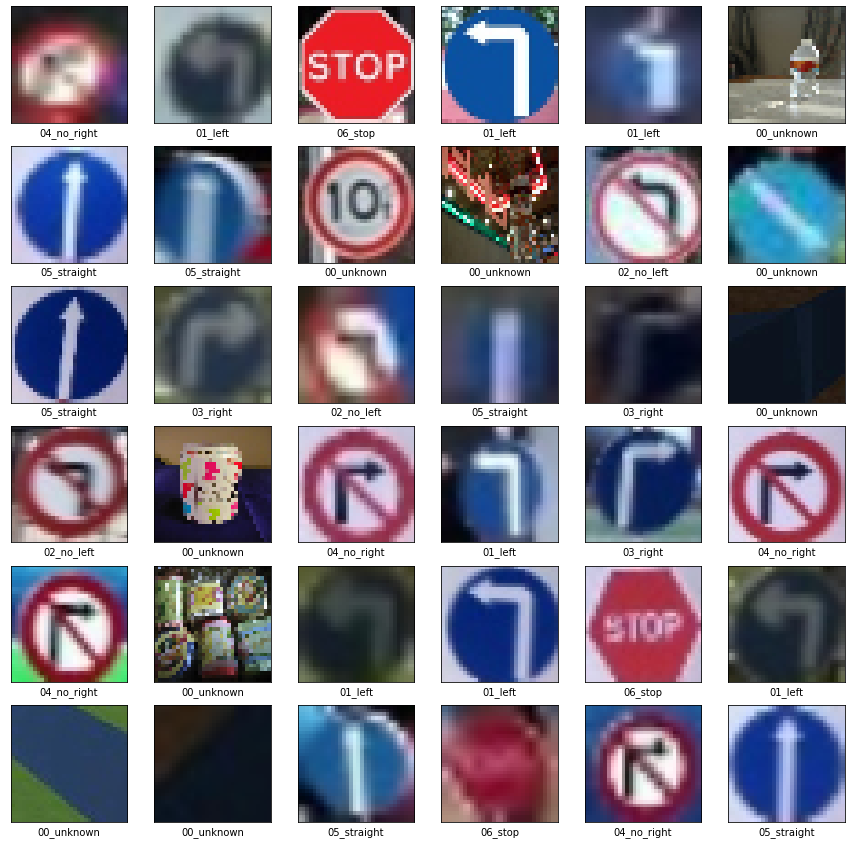

In [ ]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(36):
    image_path = np.random.choice(all_img_paths)
    image = plt.imread(image_path)
    image = cv2.resize(image, (32, 32))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Split the dataset
 
For simplicity, we split the data into only two subsets: training set (80%) and validation set (20%). You can also hold out some images for the test set by modifying following blocks.

After spliting, our dataset structure should be like following:

```
/content
    + /train
        + /00_unknown
        + /01_left
        + /02_no_left
        + /03_right
        + /04_no_right
        + /05_straight
        + /06_stop
    + /val
        + /00_unknown
        + /01_left
        + /02_no_left
        + /03_right
        + /04_no_right
        + /05_straight
        + /06_stop
```


In [ ]:
!rm -rf /content/data/

In [ ]:
val_ratio = 0.20
train_dir = "/content/data/train"
val_dir = "/content/data/val"

In [ ]:
val_imgs = int(len(all_img_paths) * val_ratio)
train_imgs = len(all_img_paths) - val_imgs
train_img_paths = all_img_paths[:train_imgs]
test_img_paths = all_img_paths[train_imgs:]

In [ ]:
# Function for copying images into subset folder
def copy_images(img_paths, output_dir):
	for imagePath in img_paths:
		# extract the label from the current image path
		label = imagePath.split("/")[1]

		# check if a directory for the label exists, if not, create it
		imageDir = os.path.join(output_dir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# copy the current image to the respective folder
		shutil.copy2(imagePath, imageDir)

In [ ]:
copy_images(train_img_paths, train_dir)
copy_images(test_img_paths, val_dir)

### Prepare data generator

We will use Keras `ImageDataGenerator` to feed data for training and validation. Images will be loaded automatically by the generators, transformed with augmentation methods, and resized to the same size of model input (32x32).

In [ ]:
# Switch to /content/data
%cd /content/data

/content/data


In [ ]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.,
								horizontal_flip=False,
								vertical_flip=False,
								brightness_range=[0.8, 1.2],
								shear_range=0.2,
								zoom_range=0.2,
								width_shift_range=0.2,
								height_shift_range=0.2,
								channel_shift_range=0.5)

val_aug = ImageDataGenerator(rescale=1/255.,
                             horizontal_flip=False,
							 vertical_flip=False,)

print("Training set")
train_gen = train_aug.flow_from_directory(train_dir,
    class_mode="categorical",
    target_size=(32, 32),
	color_mode="rgb",
	shuffle=True,
	batch_size=batch_size
)

print("Validation set")
val_gen = train_aug.flow_from_directory(val_dir,
    class_mode="categorical",
    target_size=(32, 32),
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size
)
num_classes = len(train_gen.class_indices.keys())
print("Set number of classes to {}".format(num_classes))

Training set
Found 14463 images belonging to 7 classes.
Validation set
Found 3615 images belonging to 7 classes.
Set number of classes to 7


In [ ]:
# Get the class labels and export to labels.txt
print(train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'00_unknown': 0, '01_left': 1, '02_no_left': 2, '03_right': 3, '04_no_right': 4, '05_straight': 5, '06_stop': 6}


In [ ]:
# Save number of training and validation samples to use later
num_train_samples = len(list(paths.list_images("train")))
num_val_samples = len(list(paths.list_images("val")))
print("Train: {} images, Val: {} images".format(num_train_samples, num_val_samples))

Train: 14463 images, Val: 3615 images


## II. Training

In this section, we build and train an image classification model based on prepared data. The function `build_model` below helps us to prepare the model. We use LeNet as the backbone for feature extraction, then attach a `Flatten` layer and some more fully connected layers for classification.


In [ ]:
# Switch to /content
%cd /content

/content


In [ ]:
def build_model():
    classifier = Sequential()
    classifier.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Flatten())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(num_classes, activation='softmax'))
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(learning_rate),
                          metrics=["accuracy"])
    return classifier

In [ ]:
# Build model
classification_model = build_model()

# Setup a callback to save the best model
best_model_path = "best_model_checkpoint.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start = time.time()
history = classification_model.fit(train_gen,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=val_gen,
    validation_steps=num_val_samples // batch_size,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback]
)
print("Total training time: ", time.time()-start)

# Load the best model weights
classification_model.load_weights(best_model_path)

Epoch 1/45
225/225 [==============================] - 46s 162ms/step - loss: 1.2945 - accuracy: 0.4452 - val_loss: 0.7107 - val_accuracy: 0.7210
Epoch 2/45
225/225 [==============================] - 39s 175ms/step - loss: 0.6567 - accuracy: 0.7198 - val_loss: 0.3347 - val_accuracy: 0.9157
Epoch 3/45
225/225 [==============================] - 39s 173ms/step - loss: 0.4204 - accuracy: 0.8421 - val_loss: 0.1915 - val_accuracy: 0.9540
Epoch 4/45
225/225 [==============================] - 35s 158ms/step - loss: 0.3245 - accuracy: 0.8899 - val_loss: 0.1557 - val_accuracy: 0.9478
Epoch 5/45
225/225 [==============================] - 39s 174ms/step - loss: 0.2788 - accuracy: 0.9058 - val_loss: 0.1159 - val_accuracy: 0.9688
Epoch 6/45
225/225 [==============================] - 39s 174ms/step - loss: 0.2588 - accuracy: 0.9144 - val_loss: 0.1054 - val_accuracy: 0.9732
Epoch 7/45
225/225 [==============================] - 39s 173ms/step - loss: 0.2194 - accuracy: 0.9274 - val_loss: 0.1284 - val_ac

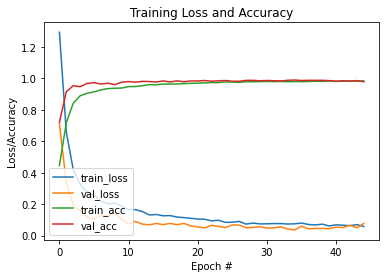

In [ ]:
# Plot training graph
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
eval_result = classification_model.evaluate(val_gen)
val_accuracy = eval_result[1]
print("Model accuracy on validation set: {}".format(val_accuracy))

## III. Model conversion

In order to have a model which can be used with OpenCV DNN, we convert the trained model into [ONNX format](https://onnx.ai/).

In [ ]:
!pip install -U tf2onnx

In [ ]:
import onnx
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(classification_model, opset=11, output_path="traffic_sign_classifier.onnx")
output_names = [n.name for n in onnx_model.graph.output]
print("Output names: ", output_names)

Now you can look into the left sidebar, open file browser and download model `traffic_sign_detection.onnx`. This model can be used with VIA project.